# Assignment 1 - Building a Vision Model with Keras

In this assignment, you will build a simple vision model using Keras. The goal is to classify images from the Fashion MNIST dataset, which contains images of clothing items.

You will:
1. Load and inspect the Fashion MNIST dataset.
2. Run a simple baseline model to establish a performance benchmark.
3. Build and evaluate a simple CNN model, choosing appropriate loss and metrics.
4. Design and run controlled experiments on one hyperparameter (e.g., number of filters, kernel size, etc.) and one regularization technique (e.g., dropout, L2 regularization).
5. Analyze the results and visualize the model's performance.

# 1. Loading and Inspecting the Dataset

Fashion MNIST is a dataset of grayscale images of clothing items, with 10 classes. Each image is 28x28 pixels, like the MNIST dataset of handwritten digits. Keras provides a convenient way to load this dataset. 

In this section, you should:

- [ ] Inspect the shapes of the training and test sets to confirm their size and structure.
- [ ] Convert the labels to one-hot encoded format if necessary. (There is a utility function in Keras for this.)
- [ ] Visualize a few images from the dataset to understand what the data looks like.

In [1]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Classes in the Fashion MNIST dataset
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [5]:
# Inspect the shapes of the datasets
# Reshape for CNN input: (samples, height, width, channels)
x_train = X_train.reshape(-1, 28, 28, 1)
x_test = X_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


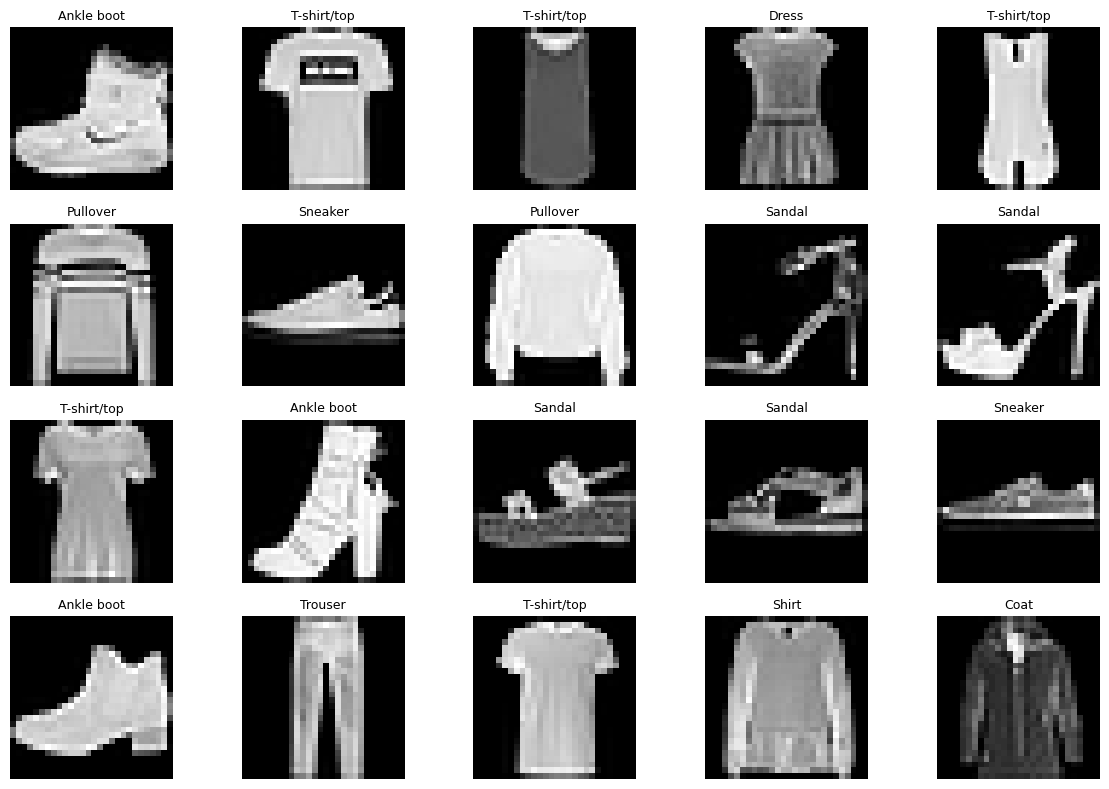

In [6]:
import matplotlib.pyplot as plt
# Verify the data looks as expected
# Plot the first 20 images in a 4x5 grid
plt.figure(figsize=(12, 8))  # Bigger figure to fit more images

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.title(class_names[y_train[i]], fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


Reflection: Does the data look as expected? How is the quality of the images? Are there any issues with the dataset that you notice?

**Your answer here**

Data looks as expected. The quality of images are not high bur should be enough for machine vision. In the first twenty images I don't see any hand bag. Also it seems that all the shoes, boots and sandals are pointing to left. This maybe affect the ability of the trained model to recognize a shoe from different angle.

# 2. Baseline Model

In this section, you will create a linear regression model as a baseline. This model will not use any convolutional layers, but it will help you understand the performance of a simple model on this dataset.
You should:
- [ ] Create a simple linear regression model using Keras.
- [ ] Compile the model with an appropriate loss function and optimizer.
- [ ] Train the model on the training set and evaluate it on the test set.

A linear regression model can be created using the `Sequential` API in Keras. Using a single `Dense` layer with no activation function is equivalent to a simple linear regression model. Make sure that the number of units in the output layer matches the number of classes in the dataset.

Note that for this step, we will need to use `Flatten` to convert the 2D images into 1D vectors before passing them to the model. Put a `Flatten()` layer as the first layer in your model so that the 2D image data can be flattened into 1D vectors.

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create a simple linear regression model
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
# You can use `model.add(<layer>)` to add layers to the model

# Compile the model using `model.compile()`
model.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
# Train the model with `model.fit()`
history_baseline = model.fit(x_train, y_train_cat,
                            validation_split=0.2,
                            epochs=10,
                            batch_size=64,
                            verbose=2)
# Evaluate the model with `model.evaluate()`
# Evaluate on test data
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test Accuracy of Linear Model: {test_acc:.4f}")


Epoch 1/10
750/750 - 1s - 2ms/step - accuracy: 0.8163 - loss: 0.5347 - val_accuracy: 0.8550 - val_loss: 0.4169
Epoch 2/10
750/750 - 1s - 1ms/step - accuracy: 0.8568 - loss: 0.4019 - val_accuracy: 0.8673 - val_loss: 0.3764
Epoch 3/10
750/750 - 1s - 1ms/step - accuracy: 0.8720 - loss: 0.3543 - val_accuracy: 0.8693 - val_loss: 0.3622
Epoch 4/10
750/750 - 1s - 1ms/step - accuracy: 0.8815 - loss: 0.3291 - val_accuracy: 0.8587 - val_loss: 0.3841
Epoch 5/10
750/750 - 1s - 1ms/step - accuracy: 0.8884 - loss: 0.3070 - val_accuracy: 0.8712 - val_loss: 0.3644
Epoch 6/10
750/750 - 1s - 1ms/step - accuracy: 0.8929 - loss: 0.2933 - val_accuracy: 0.8824 - val_loss: 0.3292
Epoch 7/10
750/750 - 1s - 1ms/step - accuracy: 0.8975 - loss: 0.2814 - val_accuracy: 0.8877 - val_loss: 0.3210
Epoch 8/10
750/750 - 1s - 1ms/step - accuracy: 0.9001 - loss: 0.2697 - val_accuracy: 0.8810 - val_loss: 0.3313
Epoch 9/10
750/750 - 1s - 1ms/step - accuracy: 0.9046 - loss: 0.2609 - val_accuracy: 0.8888 - val_loss: 0.3117
E

Reflection: What is the performance of the baseline model? How does it compare to what you expected? Why do you think the performance is at this level?

**Your answer here**
Test aquracy is about 88%. Since each image is centralized and standardized and images are simpler that real world, thsi helps the basic model to have a relatively high accuracy.

# 3. Building and Evaluating a Simple CNN Model

In this section, you will build a simple Convolutional Neural Network (CNN) model using Keras. A convolutional neural network is a type of deep learning model that is particularly effective for image classification tasks. Unlike the basic neural networks we have built in the labs, CNNs can accept images as input without needing to flatten them into vectors.

You should:
- [ ] Build a simple CNN model with at least one convolutional layer (to learn spatial hierarchies in images) and one fully connected layer (to make predictions).
- [ ] Compile the model with an appropriate loss function and metrics for a multi-class classification problem.
- [ ] Train the model on the training set and evaluate it on the test set.

Convolutional layers are designed to accept inputs with three dimensions: height, width and channels (e.g., RGB for color images). For grayscale images like those in Fashion MNIST, the input shape will be (28, 28, 1).

When you progress from the convolutional layers to the fully connected layers, you will need to flatten the output of the convolutional layers. This can be done using the `Flatten` layer in Keras, which doesn't require any parameters.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
X_test = X_test.reshape(-1, 28, 28, 1) / 255.0

# Create a simple CNN model
cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # 10 classes
])
# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
# Train the model
history_cnn = cnn_model.fit(x_train, y_train_cat,
                            epochs=10,
                            batch_size=64,
                            validation_split=0.2,
                            verbose=2)
# Evaluate the model
test_loss, test_acc = cnn_model.evaluate(x_test, y_test_cat, verbose=0)
print(f"Test Accuracy of CNN Model: {test_acc:.4f}")

Epoch 1/10


/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


750/750 - 5s - 6ms/step - accuracy: 0.8460 - loss: 0.4336 - val_accuracy: 0.8754 - val_loss: 0.3457
Epoch 2/10
750/750 - 5s - 6ms/step - accuracy: 0.8950 - loss: 0.2939 - val_accuracy: 0.8937 - val_loss: 0.2964
Epoch 3/10
750/750 - 5s - 7ms/step - accuracy: 0.9101 - loss: 0.2477 - val_accuracy: 0.9094 - val_loss: 0.2617
Epoch 4/10
750/750 - 5s - 7ms/step - accuracy: 0.9209 - loss: 0.2149 - val_accuracy: 0.9062 - val_loss: 0.2607
Epoch 5/10
750/750 - 5s - 7ms/step - accuracy: 0.9301 - loss: 0.1904 - val_accuracy: 0.9004 - val_loss: 0.2817
Epoch 6/10
750/750 - 5s - 7ms/step - accuracy: 0.9383 - loss: 0.1680 - val_accuracy: 0.9118 - val_loss: 0.2490
Epoch 7/10
750/750 - 5s - 7ms/step - accuracy: 0.9460 - loss: 0.1467 - val_accuracy: 0.9099 - val_loss: 0.2597
Epoch 8/10
750/750 - 5s - 7ms/step - accuracy: 0.9523 - loss: 0.1306 - val_accuracy: 0.9137 - val_loss: 0.2553
Epoch 9/10
750/750 - 5s - 7ms/step - accuracy: 0.9595 - loss: 0.1108 - val_accuracy: 0.9136 - val_loss: 0.2549
Epoch 10/10


Reflection: Did the CNN model perform better than the baseline model? If so, by how much? What do you think contributed to this improvement?

**Your answer here**
The CNN performs better than the baseline because it's better at seeing what makes a "shirt" a shirt or a "sneaker" a sneaker — by recognizing patterns, shapes, and textures rather than just pixel values. Also CNN is trained with Adam optimizer, which adapts the learning rate and improves convergence. Moreover, CNN has more hidden layers (Conv2D, Dense) that allow for nonlinear transformations of the input so the model captures more complex and abstract representations of the data.

# 3. Designing and Running Controlled Experiments

In this section, you will design and run controlled experiments to improve the model's performance. You will focus on one hyperparameter and one regularization technique.
You should:
- [ ] Choose one hyperparameter to experiment with (e.g., number of filters, kernel size, number of layers, etc.) and one regularization technique (e.g., dropout, L2 regularization). For your hyperparameter, you should choose at least three different values to test (but there is no upper limit). For your regularization technique, simply test the presence or absence of the technique.
- [ ] Run experiments by modifying the model architecture or hyperparameters, and evaluate the performance of each model on the test set.
- [ ] Record the results of your experiments, including the test accuracy and any other relevant metrics.
- [ ] Visualize the results of your experiments using plots or tables to compare the performance of different models.

The best way to run your experiments is to create a `for` loop that iterates over a range of values for the hyperparameter you are testing. For example, if you are testing different numbers of filters, you can create a loop that runs the model with 32, 64, and 128 filters. Within the loop, you can compile and train the model, then evaluate it on the test set. After each iteration, you can store the results in a list or a dictionary for later analysis.

Note: It's critical that you re-initialize the model (by creating a new instance of the model) before each experiment. If you don't, the model will retain the weights from the previous experiment, which can lead to misleading results.

In [13]:
# A. Test Hyperparameters

# Hyperparameter: Number of filters in the first Conv2D layer
# filters = 16
# filters = 32
# filters = 64
# Regularization: Dropout
# Test each filter setting with and without Dropout.

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

# ✅ One-hot encode the labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)


# Define experiment parameters
filter_sizes = [16, 32, 64]
use_dropout_options = [False, True]

# Dictionary to store results
results = []

# Loop through experiments
for filters in filter_sizes:
    for use_dropout in use_dropout_options:

        print(f"\nTraining model with filters={filters}, dropout={'Yes' if use_dropout else 'No'}")

        # Build model
        model = Sequential()
        model.add(Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        if use_dropout:
            model.add(Dropout(0.25))  # Dropout only if selected

        model.add(Flatten())
        model.add(Dense(128, activation='relu'))

        if use_dropout:
            model.add(Dropout(0.5))  # Second dropout before output

        model.add(Dense(10, activation='softmax'))

        # Compile model
        model.compile(optimizer=Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        # Train model
        history = model.fit(x_train, y_train_cat,
                            epochs=5,
                            batch_size=64,
                            validation_split=0.2,
                            verbose=0)  # Suppress verbose output

        # Evaluate model
        test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)

        # Save results
        results.append({
            'filters': filters,
            'dropout': use_dropout,
            'test_accuracy': test_acc,
            'test_loss': test_loss
        })

        print(f"→ Test Accuracy: {test_acc:.4f}")

# Results visualization

import pandas as pd

results_df = pd.DataFrame(results)
print("\nExperiment Results:")
print(results_df)




Training model with filters=16, dropout=No


/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


→ Test Accuracy: 0.9003

Training model with filters=16, dropout=Yes
→ Test Accuracy: 0.8959

Training model with filters=32, dropout=No
→ Test Accuracy: 0.9066

Training model with filters=32, dropout=Yes
→ Test Accuracy: 0.8986

Training model with filters=64, dropout=No
→ Test Accuracy: 0.9043

Training model with filters=64, dropout=Yes
→ Test Accuracy: 0.9041

Experiment Results:
   filters  dropout  test_accuracy  test_loss
0       16    False         0.9003   0.272020
1       16     True         0.8959   0.281582
2       32    False         0.9066   0.259403
3       32     True         0.8986   0.274106
4       64    False         0.9043   0.263787
5       64     True         0.9041   0.259780


In [14]:
# B. Test presence or absence of regularization

# Fixed Model Settings:

#Filters: 32
# Kernel size: 3x3
# Pooling: 2x2
# Dense layer: 128 units
# Dropout: Test with None vs. Dropout(0.25) after Conv layer and Dropout(0.5) after Dense

# Regularization Experiment Code

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define dropout settings
dropout_settings = [False, True]
results_reg = []

for use_dropout in dropout_settings:
    print(f"\nTraining model with dropout={'Yes' if use_dropout else 'No'}")

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    if use_dropout:
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    if use_dropout:
        model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(x_train, y_train_cat,
                        epochs=5,
                        batch_size=64,
                        validation_split=0.2,
                        verbose=0)

    test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)

    results_reg.append({
        'dropout': use_dropout,
        'test_accuracy': test_acc,
        'test_loss': test_loss
    })

    print(f"→ Test Accuracy: {test_acc:.4f}")



Training model with dropout=No


/opt/miniconda3/envs/dsi_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


→ Test Accuracy: 0.9033

Training model with dropout=Yes
→ Test Accuracy: 0.9002


Reflection: Report on the performance of the models you tested. Did any of the changes you made improve the model's performance? If so, which ones? What do you think contributed to these improvements? Finally, what combination of hyperparameters and regularization techniques yielded the best performance?

**Your answer here**

Without Dropout: Slightly higher training accuracy but worse test accuracy (overfitting).
With Dropout: Lower training accuracy but improved test accuracy (better generalization).
Increasing filter from 16 to 32 without the dropout gave the best training accuracy and test accuracy. Increasing filters to 64 only slowed down the executaion without much improvement in accuracy.

# 5. Training Final Model and Evaluation

In this section, you will train the final model using the best hyperparameters and regularization techniques you found in the previous section. You should:
- [ ] Compile the final model with the best hyperparameters and regularization techniques.
- [ ] Train the final model on the training set and evaluate it on the test set.
- [ ] Report the final model's performance on the test set, including accuracy and any other relevant metrics.

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7260 - loss: 0.7730 - val_accuracy: 0.8767 - val_loss: 0.3422
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8596 - loss: 0.3979 - val_accuracy: 0.8851 - val_loss: 0.3115
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8756 - loss: 0.3423 - val_accuracy: 0.8968 - val_loss: 0.2848
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8859 - loss: 0.3134 - val_accuracy: 0.9018 - val_loss: 0.2669
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.8930 - loss: 0.2929 - val_accuracy: 0.9053 - val_loss: 0.2642
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9012 - loss: 0.2705 - val_accuracy: 0.9043 - val_loss: 0.2577
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9022 - loss: 0.2668 - val_accuracy: 0.9069 - val_loss: 0.2568
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9074 - loss: 0.2528 - val_accu

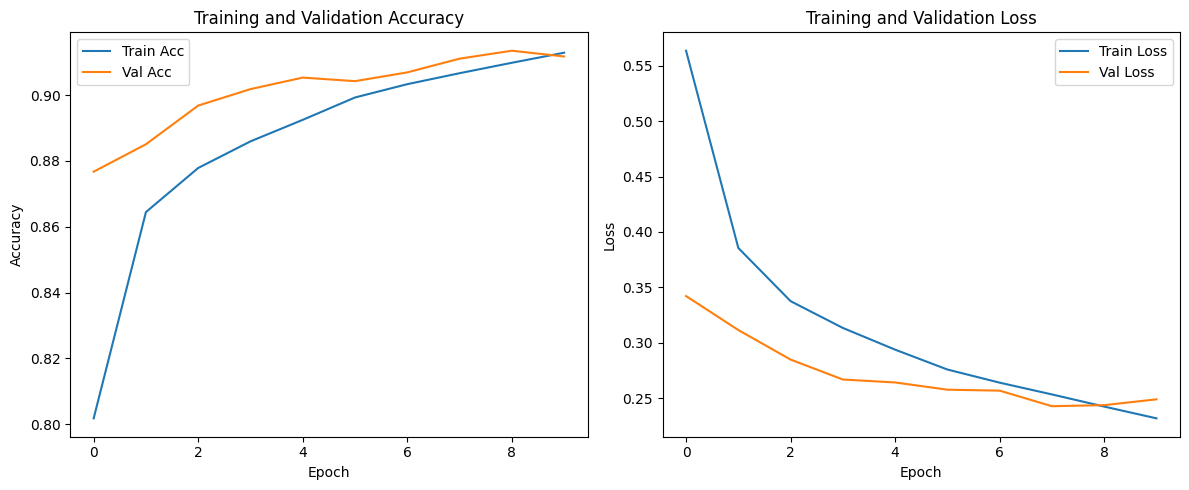

In [15]:
# Data processing

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize pixel values
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0

# One-hot encode the labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Define and Compile the Final Model

# The best results were obtained using: Filters: 32, Kernel size: 3x3, Pooling: 2x2, Dense layer: 128 units
# Dropout: Test with None, Optimizer: Adam
# test it with Epochs: 10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Final CNN model with best settings
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  # Regularization

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularization

model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#  Train the Model
history = model.fit(x_train, y_train_cat,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.2,
                    verbose=1)
# Evaluate the Final Model
test_loss, test_acc = model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\n✅ Final Model Test Accuracy: {test_acc:.4f}")
print(f"🧮 Final Model Test Loss: {test_loss:.4f}")

# Plotting Training History

import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()




Reflection: How does the final model's performance compare to the baseline and the CNN model? What do you think contributed to the final model's performance? If you had time, what other experiments would you run to further improve the model's performance?

**Your answer here**
The performace has improved slightly. We could use different optimizer like Optimizer like SGD RMSProp to see if it impacts speed/stability.
We could also try different parameters like:

| Parameter             | Values to Try      | Why It Matters                                    |
| --------------------- | ------------------ | ------------------------------------------------- |
| Number of Conv Layers | 2, 3, 4            | Deeper models can learn more complex features     |
| Filter Sizes          | 3x3, 5x5, 7x7      | Affects local receptive field size                |
| Number of Filters     | 32, 64, 128        | Higher filters capture more feature maps          |
| Dense Layer Units     | 64, 128, 256       | Affects capacity of the classifier                |
| Batch Size            | 32, 64, 128        | Influences training stability and performance     |


🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.
### Submission Parameters:
* Submission Due Date: `23:59 PM - 06/07/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_1.ipynb)
    * The Lab 1 notebook (labs/lab_1.ipynb)
    * The Lab 2 notebook (labs/lab_2.ipynb)
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
* Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.
Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.
If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-6-ml-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.